In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
import re

## Read weekly data

In [2]:
start_date = date(2021, 10 ,27)
raw_data = pd.read_csv("weekly/evaluation_{}.csv".format(start_date.strftime("%Y%m%d")))

In [3]:
new_date = start_date
while True:
    new_date = new_date + timedelta(7)
    try:
        raw_data = raw_data.append(pd.read_csv("weekly/evaluation_{}.csv".format(new_date.strftime("%Y%m%d"))))
    except:
        break

In [4]:
raw_data

,model,target,horizon,forecast_date,q0.025,q0.25,q0.5,q0.75,q0.975,value,qscore_q0.025,qscore_q0.25,qscore_q0.5,qscore_q0.75,qscore_q0.975,mean_qscore,ae,interval_coverage_0.5,interval_coverage_0.95,scores_imputed
0,GeneralGrievous,DAX,1 day,2021-10-27,-2.950348,-1.095254,-0.121883,0.851487,2.706582,-0.060375,0.144499,0.517439,0.061509,0.455931,0.138348,0.263545,0.061509,True,True,NaN
1,AryaStark,DAX,1 day,2021-10-27,-2.294067,-0.422822,0.051950,0.540928,2.105637,-0.060375,0.111685,0.181223,0.112325,0.300651,0.108301,0.162837,0.112325,True,True,NaN
2,DougJudy,DAX,1 day,2021-10-27,0.098211,0.098224,0.098231,0.098238,0.098250,-0.060375,0.309243,0.237898,0.158606,0.079306,0.007931,0.158597,0.158606,False,False,NaN
3,GinaLinetti,DAX,1 day,2021-10-27,-5.687000,-5.232000,-4.730000,-3.767000,-2.658000,-0.060375,0.281331,2.585813,4.669625,5.559938,5.065369,3.632415,4.669625,False,False,NaN
4,CaptainRaymondHolt,DAX,1 day,2021-10-27,-2.502641,-0.423577,0.075881,0.674492,2.657910,-0.060375,0.122113,0.181601,0.136255,0.367433,0.135914,0.188664,0.136255,True,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,DAX_benchmark,temperature,84 hour,2021-11-24,NaN,NaN,NaN,NaN,NaN,3.300000,NaN,NaN,NaN,NaN,NaN,7.396005,8.622552,False,False,True
416,JabbaTheHutt,temperature,84 hour,2021-11-24,NaN,NaN,NaN,NaN,NaN,3.300000,NaN,NaN,NaN,NaN,NaN,7.396005,8.622552,False,False,True
417,RossGeller,temperature,84 hour,2021-11-24,NaN,NaN,NaN,NaN,NaN,3.300000,NaN,NaN,NaN,NaN,NaN,7.396005,8.622552,False,False,True
418,wind_benchmark,temperature,84 hour,2021-11-24,NaN,NaN,NaN,NaN,NaN,3.300000,NaN,NaN,NaN,NaN,NaN,7.396005,8.622552,False,False,True


## Filter data

In [5]:
data = raw_data.loc[raw_data["model"] == "HanSolo"]
data["horizon"] = data["horizon"].apply(lambda x: re.findall(r'\d+', x)[0])
data = data.astype({"horizon":"float64"})
data["forecast_date"] = pd.to_datetime(data["forecast_date"])
data = data.reset_index().drop("index", axis = 1)

C:\Users\chris\AppData\Local\Temp/ipykernel_32572/3892431281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["horizon"] = data["horizon"].apply(lambda x: re.findall(r'\d+', x)[0])


# Dax evaluation

In [6]:
dax_data = data[data["target"] == "DAX"].copy()

In [7]:
for horizon in dax_data["horizon"].unique():
    dax_data.loc[dax_data["horizon"] == horizon, "forecast_date"] = dax_data.loc[dax_data["horizon"] == horizon, "forecast_date"] + timedelta(horizon)

In [8]:
dax_data

,model,target,horizon,forecast_date,q0.025,q0.25,q0.5,q0.75,q0.975,value,qscore_q0.025,qscore_q0.25,qscore_q0.5,qscore_q0.75,qscore_q0.975,mean_qscore,ae,interval_coverage_0.5,interval_coverage_0.95,scores_imputed
0,HanSolo,DAX,1.0,2021-10-28,-1.842954,-0.568223,0.064408,0.764962,2.687890,-0.060375,0.089129,0.253924,0.124782,0.412668,0.137413,0.203583,0.124782,True,True,NaN
1,HanSolo,DAX,2.0,2021-10-29,-2.319701,-0.950494,0.137721,0.860541,2.415874,-0.108554,0.110557,0.420970,0.246275,0.484548,0.126221,0.277714,0.246275,True,True,NaN
2,HanSolo,DAX,5.0,2021-11-01,-3.290964,-0.835038,0.297649,1.055945,4.553681,0.637728,0.196435,0.736383,0.340079,0.209108,0.195798,0.335561,0.340079,True,True,NaN
3,HanSolo,DAX,6.0,2021-11-02,-3.881278,-1.112036,0.258100,1.181688,4.836495,1.570712,0.272599,1.341374,1.312611,0.583535,0.163289,0.734682,1.312611,False,True,NaN
4,HanSolo,DAX,7.0,2021-11-03,-3.935016,-1.042304,0.324122,1.946898,3.338167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,HanSolo,DAX,1.0,2021-11-04,-3.209327,-0.578244,0.077734,0.634355,1.567144,0.435579,0.182245,0.506912,0.357845,0.099388,0.056578,0.240594,0.357845,True,True,False
6,HanSolo,DAX,2.0,2021-11-05,-2.549535,-0.627582,0.120788,1.053213,2.207484,0.589612,0.156957,0.608597,0.468823,0.231800,0.080894,0.309414,0.468823,True,True,False
7,HanSolo,DAX,5.0,2021-11-08,-5.519643,-0.766162,0.194377,1.223096,2.203468,0.540761,0.303020,0.653461,0.346384,0.341168,0.083135,0.345434,0.346384,True,True,False
8,HanSolo,DAX,6.0,2021-11-09,-4.952300,-0.869202,0.241294,1.413107,3.013850,0.503052,0.272768,0.686127,0.261758,0.455028,0.125540,0.360244,0.261758,True,True,False
9,HanSolo,DAX,7.0,2021-11-10,-7.461819,-0.550829,0.368222,1.398829,4.058462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [9]:
def get_interval_plot(data):
    fig, axs = plt.subplots(figsize = (10,8))
    sns.lineplot(x = "forecast_date", y = "value", data = data, label = "True value")
    sns.lineplot(x = "forecast_date", y = "q0.5", data = data, label = "50% quantile")
    sns.lineplot(x = "forecast_date", y = "q0.025", data = data, color = "blue", label = "95% interval")
    sns.lineplot(x = "forecast_date", y = "q0.975", data = data, color = "blue")
    axs.fill_between(x = data["forecast_date"], y1 = data["q0.025"], y2 = data["q0.975"], alpha = 0.1, color = "blue")

    sns.lineplot(x = "forecast_date", y = "q0.25", data = data, color = "green", label = "50% interval")
    sns.lineplot(x = "forecast_date", y = "q0.75", data = data, color = "green")
    axs.fill_between(x = data["forecast_date"], y1 = data["q0.25"], y2 = data["q0.75"], alpha = 0.1, color = "green")
    axs.legend()

In [10]:
def get_error_plot(data, per_horizon=False):
    fig, axs = plt.subplots(figsize = (10,8))
    if per_horizon == False:
        sns.lineplot(x = "forecast_date", y = "mean_qscore", data = data)
    else:
        sns.lineplot(x = "forecast_date", y = "mean_qscore", hue = "horizon", data = data)

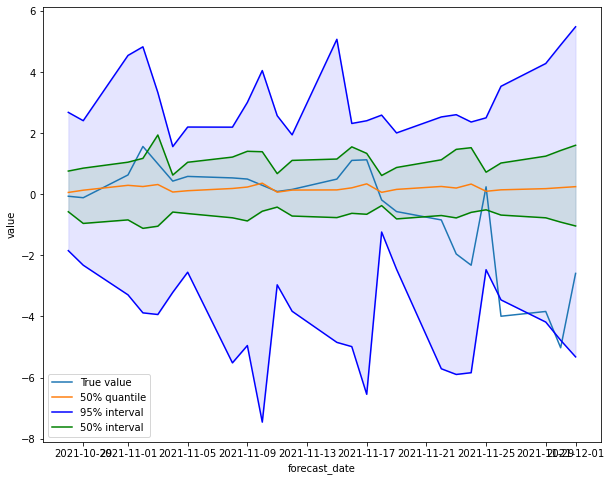

In [11]:
get_interval_plot(dax_data)

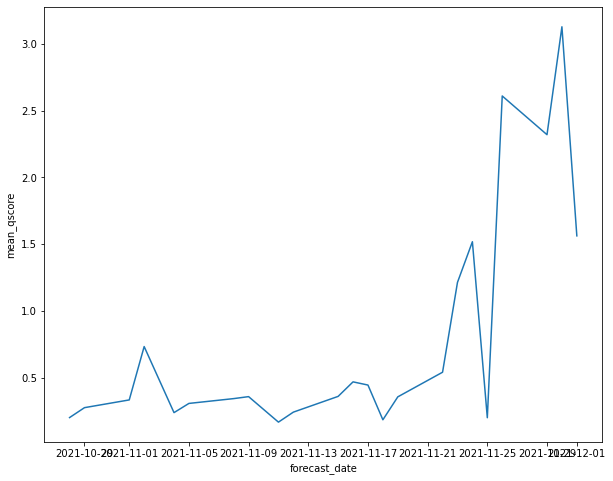

In [12]:
get_error_plot(dax_data)

# Wind evaluation

In [13]:
data[data["target"] == "wind"]

,model,target,horizon,forecast_date,q0.025,q0.25,q0.5,q0.75,q0.975,value,qscore_q0.025,qscore_q0.25,qscore_q0.5,qscore_q0.75,qscore_q0.975,mean_qscore,ae,interval_coverage_0.5,interval_coverage_0.95,scores_imputed
10,HanSolo,wind,36.0,2021-11-03,9.008980,14.112084,17.420645,20.307768,25.082108,17.28,0.413551,1.583958,0.140645,1.513884,0.390105,0.808429,0.140645,True,True,False
11,HanSolo,wind,48.0,2021-11-03,8.901674,14.817027,17.945885,21.549999,28.956566,23.40,0.724916,4.291486,5.454115,2.775001,0.277828,2.704669,5.454115,False,True,False
12,HanSolo,wind,60.0,2021-11-03,9.045424,13.840762,16.221087,18.463316,23.152771,17.28,0.411729,1.719619,1.058913,0.591658,0.293639,0.815112,1.058913,True,True,False
13,HanSolo,wind,72.0,2021-11-03,7.066521,12.672591,14.257113,17.415918,25.860399,12.96,0.294674,0.143704,1.297113,2.227959,0.645020,0.921694,1.297113,True,True,False
14,HanSolo,wind,84.0,2021-11-03,10.816050,15.574940,19.018330,21.133451,26.780411,19.44,0.431198,1.932530,0.421670,0.846726,0.367021,0.799829,0.421670,True,True,False
25,HanSolo,wind,36.0,2021-11-10,3.889780,7.935707,9.453829,10.912843,15.043772,8.64,0.237511,0.352146,0.813829,1.136421,0.320189,0.572019,0.813829,True,True,False
26,HanSolo,wind,48.0,2021-11-10,0.872828,2.127781,4.402931,7.325530,12.399355,7.92,0.352359,2.896110,3.517069,0.891705,0.223968,1.576242,3.517069,False,True,False
27,HanSolo,wind,60.0,2021-11-10,4.477252,8.904283,11.971659,13.609918,17.085695,11.52,0.352137,1.307859,0.451659,1.044959,0.278285,0.686980,0.451659,True,True,False
28,HanSolo,wind,72.0,2021-11-10,3.809932,7.771947,10.143431,12.570247,19.609003,12.60,0.439503,2.414027,2.456569,0.044630,0.350450,1.141036,2.456569,False,True,False
29,HanSolo,wind,84.0,2021-11-10,4.898277,9.537073,11.678784,14.046896,22.080448,8.64,0.187086,1.345610,3.038784,2.703448,0.672022,1.589390,3.038784,False,True,False


In [14]:
wind_data = data[data["target"] == "wind"].copy()
for horizon in wind_data["horizon"].unique():
    wind_data.loc[wind_data["horizon"] == horizon, "forecast_date"] = wind_data.loc[wind_data["horizon"] == horizon, "forecast_date"] + timedelta(hours = horizon)

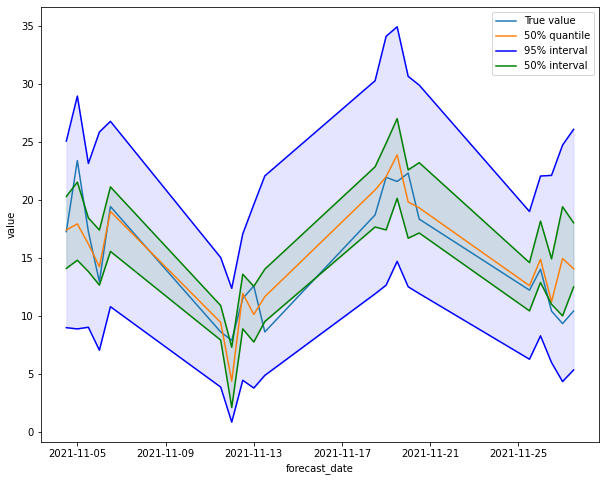

In [15]:
get_interval_plot(wind_data)

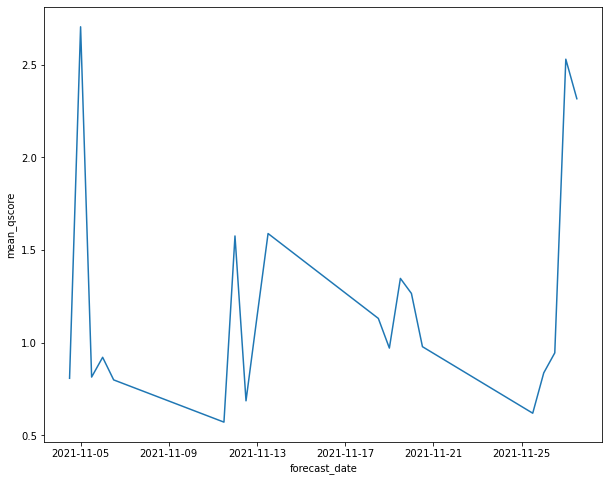

In [16]:
get_error_plot(wind_data)

# Temperature evaluation

In [17]:
temp_data = data[data["target"] == "temperature"].copy()
for horizon in temp_data["horizon"].unique():
    temp_data.loc[temp_data["horizon"] == horizon, "forecast_date"] = temp_data.loc[temp_data["horizon"] == horizon, "forecast_date"] + timedelta(hours = horizon)

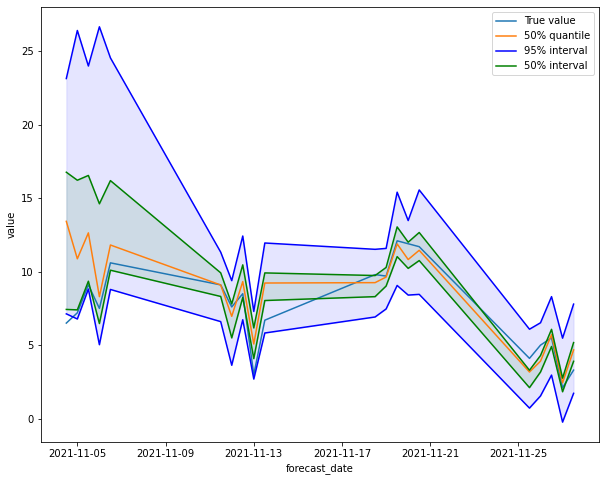

In [18]:
get_interval_plot(temp_data)

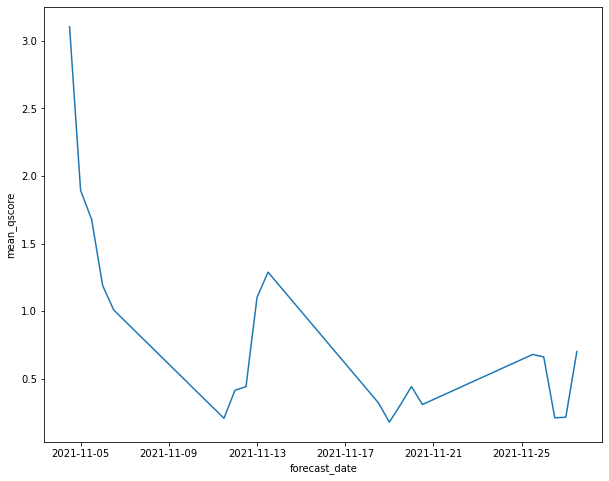

In [19]:
get_error_plot(temp_data)